In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=d665efa953081ba91c37c06459dcfb77dcb2e76b0d7a91b8d52b68548ae0479d
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
!pip install torchinfo

In [ ]:

from argparse import ArgumentParser
from collections import defaultdict
from math import ceil, sin
from math import floor


import scipy
import pandas as pd
import numpy as np

import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd.functional import jacobian
from torch.nn.modules.container import T

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib as mpl
from functools import partial

In [ ]:
from pyDOE import lhs

In [ ]:
#from torchinfo import summary

Run this notebook with cuda

In [ ]:
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=xm.xla_device()


In [ ]:
device

device(type='cuda')

In [ ]:
# Configuration and set parameters

alpha = torch.tensor(0.01)  # Example value for thermal diffusivity
hidden_dim =40
resblocks=2

hidden_layers = 0



input_dim=2
output_dim=1
lambda_f=1
 # 0 when not Resnet
activation='tanh'
learningRate=0.0001
wd=1e-4
N=3000

N_f=4000
N_u=200
n_epochs=3000
network='ResNet' # MLP Or Resnet

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Heatfinal",

    # track hyperparameters and run metadata
    config={
    "Thermal_diff": alpha,
    "N_f": N_f,
    "N_u":N_u,
    "learning_rate": learningRate,
    "weight_decay": wd,
    "hidden_layers": hidden_layers,
    "hidden_dim": hidden_dim,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation':activation,
    'lambdaB': lambda_f,
    'numResblocks': resblocks,
    "epochs": n_epochs,
    'network': network
    }
)

In [ ]:
# Plot function of the three loss terms of boundary, initial and the residual.
def plot_loss(losses):
    fig, ax = plt.subplots()
    fig.canvas.manager.set_window_title("Loss terms")

    # Extract the loss values from the dictionary
    lossNN = losses["Res"]
    lossEQ = losses["BC"]
    lossIC=losses['IC']
    lossData=losses['Data']
    # Plot both losses
    ax.plot(lossNN, label='Residual')
    ax.plot(lossEQ, label='BC')
    ax.plot(lossIC, label='IC')
    #ax.plot(lossData, label='Data')

    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Neural Network and Equation/BC/IC Losses over Epochs")
    plt.show()


In [ ]:
losses = defaultdict(list)

In [ ]:
# Xavier initialization
def xavier_init(module):
        for m in module.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)


In [ ]:
# The sinusoidal activation function
class SinusActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

In [ ]:
# MLP Neural network as a function of the number of neurons, the number of layers and the activation function
def construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation):
    # Activation function mapping
    activations = {
        'swish': nn.SiLU,
        'tanh': nn.Tanh,
        'relu': nn.ReLU,
        'gelu': nn.GELU,
        'softplus': nn.Softplus,
        'sin': SinusActivation
    }

    # Check if activation is valid
    if activation not in activations:
        raise ValueError(f"Invalid activation function. Expected one of: {list(activations.keys())}")

    ActivationFunc = activations[activation]

    # Construct the layers
    layers = [nn.Linear(input_dim, hidden_dim), ActivationFunc()]
    for _ in range(hidden_layers):
        layers.extend([nn.Linear(hidden_dim, hidden_dim), ActivationFunc()])
    layers.append(nn.Linear(hidden_dim, output_dim))
    layers.append(ActivationFunc())  # Activation function for the output layer


    # Create the network
    net = nn.Sequential(*layers).double().to(device)

    xavier_init(net)
    return net

# Example usage:
# net = construct_network(10, 2, 128, 3, 'relu', device='cuda')



In [ ]:
# The ResNet neural network as a function of neurons, the size of the output layer and the activation function
class ResidualBlockScalar(nn.Module):
    def __init__(self, features, activation_func):
        super(ResidualBlockScalar, self).__init__()
        self.linear1 = nn.Linear(features, features)
        self.linear2 = nn.Linear(features, features)
        self.activation = activation_func()

    def forward(self, x):
        residual = x
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return self.activation(x + residual)

class SimpleResNetScalar(nn.Module):
    def __init__(self, num_classes, features, num_blocks, activation='relu'):
        super(SimpleResNetScalar, self).__init__()
        activations = {
            'swish': nn.SiLU,
            'tanh': nn.Tanh,
            'relu': nn.ReLU,
            'gelu': nn.GELU,
            'softplus': nn.Softplus,
            'sin': SinusActivation  # Assuming SinusActivation is defined elsewhere
        }

        self.linear1 = nn.Linear(2, features)
        self.activation = activations[activation]()
        self.res_blocks = nn.ModuleList([ResidualBlockScalar(features, activations[activation]) for _ in range(num_blocks)])
        self.linear2 = nn.Linear(features, num_classes)
        self.final_activation = activations[activation]()  # Activation function after the final layer

    def forward(self, x):
        x = self.activation(self.linear1(x))
        for block in self.res_blocks:
            x = block(x)
        x = self.linear2(x)
        return self.final_activation(x)  # Apply activation function here

# Example instantiation
#model = SimpleResNetScalar(num_classes=output_dim, features=hidden_dim, num_blocks=resblocks, activation='swish')


In [ ]:
#summary(model)

In [ ]:

# Model parameters

# Set random seed for reproducibility
torch.manual_seed(54)
# Interior conditions
x_int=lhs(2,N_f)
x_int=torch.tensor(x_int)
u_int = torch.zeros(N_f, 1)
u_train=torch.exp(-alpha * np.pi**2 * x_int[...,0]) * torch.sin(np.pi * x_int[...,1])

# Initial conditions
x_ini = torch.rand(N_u, 2)
x_ini[..., 0] = 0  # t = 0
u_ini = torch.sin(np.pi * x_ini[..., 1]).reshape(N_u, 1)

# Boundary conditions
x_bc = torch.rand(N_u, 2)  # t, 0 to 1
x_bc[..., 1] = torch.tensor([0, 1])[torch.randint(0, 2, (N_u,))]  # 0 or 1
u_bc = torch.zeros(N_u, 1)

# Merge inputs
x_inp = torch.cat([x_int, x_bc, x_ini], dim=0).float()
u_inp = torch.cat([u_int, u_bc, u_ini], dim=0).float()

# Print shapes to verify
print(f"x_inp shape: {x_inp.shape}, u_inp shape: {u_inp.shape}")
x_bc_inp = x_bc
x_ini_inp = x_ini
x_inp = x_int
u_bc_inp = u_bc
u_ini_inp = u_ini
#u_inp = u_int

x_inp = torch.reshape(x_inp,(-1,2));
u_inp = torch.reshape(u_inp,(-1,1));

x_bc_inp = torch.reshape(x_bc_inp,(-1,2));
u_bc_inp = torch.reshape(u_bc_inp,(-1,1));

x_ini_inp = torch.reshape(x_ini_inp,(-1,2));
u_ini_inp = torch.reshape(u_ini_inp,(-1,1));


x_inp shape: torch.Size([4400, 2]), u_inp shape: torch.Size([4400, 1])


In [ ]:
# Initialize the model
#model = PINN()
#model=construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation)
model = SimpleResNetScalar(num_classes=output_dim, features=hidden_dim, num_blocks=resblocks, activation=activation).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=wd)


In [ ]:
print(model)

SimpleResNetScalar(
  (linear1): Linear(in_features=2, out_features=40, bias=True)
  (activation): Tanh()
  (res_blocks): ModuleList(
    (0-1): 2 x ResidualBlockScalar(
      (linear1): Linear(in_features=40, out_features=40, bias=True)
      (linear2): Linear(in_features=40, out_features=40, bias=True)
      (activation): Tanh()
    )
  )
  (linear2): Linear(in_features=40, out_features=1, bias=True)
  (final_activation): Tanh()
)


In [ ]:
# Loss for data if available
def data_loss(xint,u_obs):
  u_pred=model(xint.double().to(device))
  return torch.mean((u_pred.flatten()-u_obs.double().to(device).flatten())**2)

In [ ]:
def initial_loss(xinit,uinit):
  # Predictions for initial
  u_ini_pred = model(xinit.double().to(device))
  # return initial loss
  return torch.mean((u_ini_pred.flatten() - uinit.double().to(device).flatten()) ** 2)

In [ ]:
def boundary_loss(xbc,ubc):
  # Predictions for boundary conditions
  u_bc_pred = model(xbc.double().to(device))
  # return loss for boundary conditions
  return torch.mean((u_bc_pred.flatten() - ubc.double().to(device).flatten()) ** 2)

In [ ]:
def Heat(x_data):
  # Calculate prediction of u dependent on x, t
  x_physics = x_data.requires_grad_(True)
  u = model(x_physics.double().to(device))
  # Calculate the grad of u with respect to x
  grad_u = torch.autograd.grad(u, x_physics, grad_outputs=torch.ones_like(u)
                               , create_graph=True)[0]
  u_t = grad_u[:, 0] # The first derivative of u with respect to t
  u_x = grad_u[:, 1] # The first derivative of u with respect to x
  # Compute the second derivative of u with respect to x
  u_xx = torch.autograd.grad(u_x, x_physics, grad_outputs=torch.ones_like(u_x)
  , create_graph=True)[0][:, 1]
  pde_residual = u_t - alpha*u_xx
  return torch.mean(pde_residual**2)


In [ ]:
loss_history = []
losses={}
losses["Res"] = []
losses["BC"] = []
losses['IC']=[]
losses['Data']=[]


# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Loss initial condition
    loss_initial = initial_loss(x_ini_inp, u_ini_inp)
    # loss boundary condition
    loss_boundary = boundary_loss(x_bc_inp, u_bc_inp)

    # Loss physics equation
    loss_physics = Heat(x_inp)
    #loss_data=data_loss(x_inp,u_train)
    # Total loss
    total_loss = lambda_f*(loss_physics) +loss_initial + loss_boundary
    #+loss_data
    loss_history.append(total_loss.item())
    # Backwadation
    total_loss.backward()
    # Optimize
    optimizer.step()
    losses['Res'].append(loss_physics.item())
    losses['BC'].append(loss_boundary.item())
    losses['IC'].append(loss_initial.item())
    #losses['Data'].append(loss_data.item())
    wandb.log({"lossRES": loss_physics,
                       "lossInitial ": loss_initial,
                       "LossBoundary": loss_boundary,
                        "LossTotal": total_loss})
    if epoch % 100 == 0:
       print(f'Epoch {epoch}, Loss: {total_loss.item()}')



Epoch 0, Loss: 0.5531875124513406
Epoch 100, Loss: 0.26258288725744516
Epoch 200, Loss: 0.24036971643170874
Epoch 300, Loss: 0.20168954221743443
Epoch 400, Loss: 0.11964461032701049
Epoch 500, Loss: 0.04460312342563678
Epoch 600, Loss: 0.01720413234044558
Epoch 700, Loss: 0.009277937422026556
Epoch 800, Loss: 0.006557804406262057
Epoch 900, Loss: 0.005341248747512289
Epoch 1000, Loss: 0.004678857958708885
Epoch 1100, Loss: 0.004248788581946187
Epoch 1200, Loss: 0.003916997901195857
Epoch 1300, Loss: 0.0036272726097456927
Epoch 1400, Loss: 0.003358138520988516
Epoch 1500, Loss: 0.0031034266938697263
Epoch 1600, Loss: 0.0028631056533827736
Epoch 1700, Loss: 0.0026385709170002446
Epoch 1800, Loss: 0.00243050122459048
Epoch 1900, Loss: 0.0022385219145731996
Epoch 2000, Loss: 0.00206170999968849
Epoch 2100, Loss: 0.0018991032922415138
Epoch 2200, Loss: 0.0017499051144964162
Epoch 2300, Loss: 0.0016134443133478812
Epoch 2400, Loss: 0.001489053023776154
Epoch 2500, Loss: 0.001375983711809135


In [ ]:
x_sample=torch.rand(5000,2)
#x_int[..., 1] = 2 * (x_int[..., 1] - 0.5)  # shift x to [-1, 1]
x_test = x_sample[:, 1]  # Extracts the first column x
t_test = x_sample[:, 0]  # Extracts the second column t

# Analytical solution
U=np.exp(-alpha * np.pi**2 * t_test) * np.sin(np.pi * x_test)

# Predicting on the grid
with torch.no_grad():
     u_pred_grid = model(x_sample.double().to(device))

# L2 loss
L2_loss= np.linalg.norm(U-u_pred_grid[:,0].cpu(),2)/np.linalg.norm(U,2)
# MSE loss
mse_loss= F.mse_loss(U,u_pred_grid[:,0].cpu())

print('MSE loss',mse_loss.item())
print('L2 relative Error', L2_loss.item())
wandb.log({"MSEloss": mse_loss})
wandb.log({"L2loss": L2_loss})

wandb.finish()

MSE loss 0.0003251537223598782
L2 relative Error 0.026598628211682


L2loss,▁
LossBoundary,▄██▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LossTotal,█▇▇▆▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSEloss,▁
lossInitial,█▆▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lossRES,█▆▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
L2loss,0.0266
LossBoundary,0.00013
LossTotal,0.00095
MSEloss,0.00033
lossInitial,0.00062


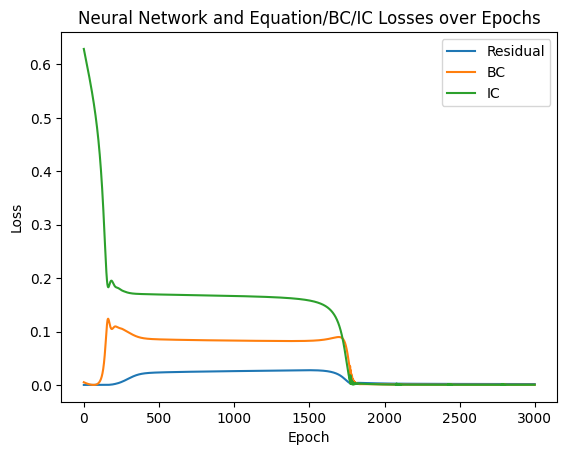

In [ ]:
plot_loss(losses)

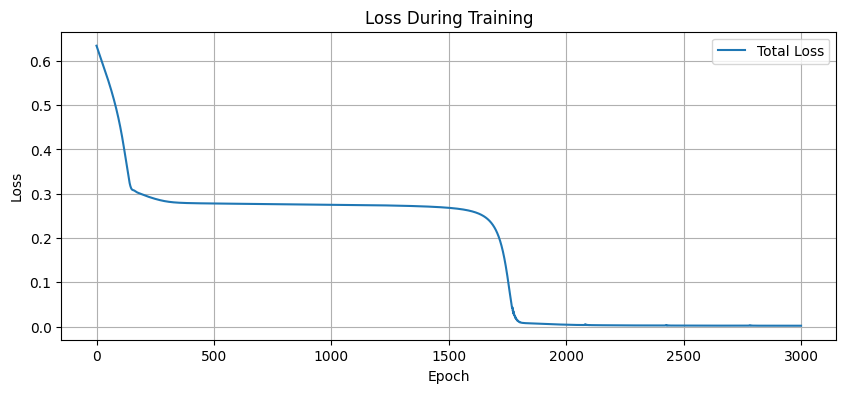

In [ ]:
# Plotting the loss history
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Generating a dense grid for prediction
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_flat = X.flatten()
T_flat = T.flatten()
input_grid = torch.tensor(np.column_stack([X_flat, T_flat]), dtype=torch.float32)
U=np.exp(-alpha * np.pi**2 * T) * np.sin(np.pi * X)

# Predicting on the grid
with torch.no_grad():
  u_pred_grid = model(input_grid.double().to(device))

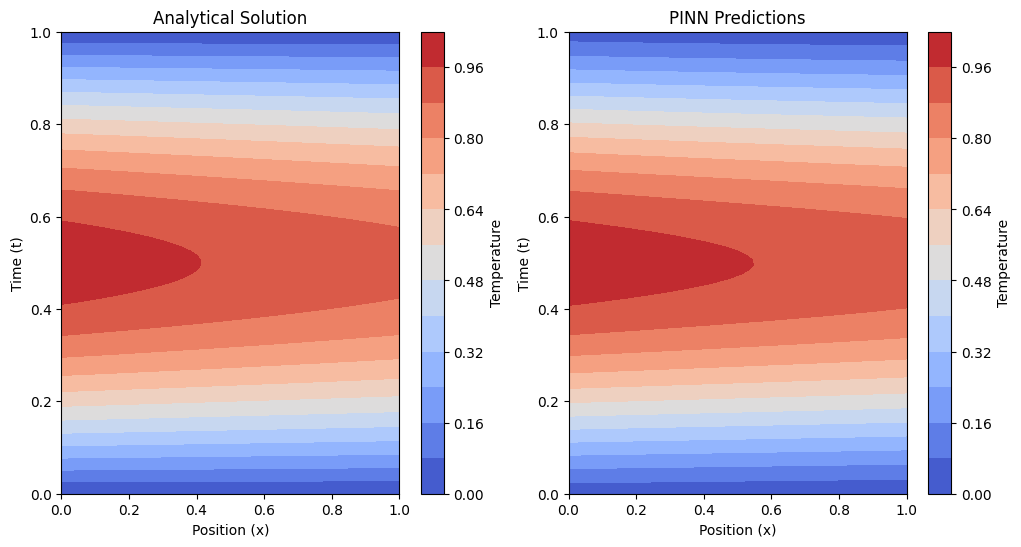

In [ ]:
u_pred_grid_reshaped = u_pred_grid.reshape(X.shape)
plt.figure(figsize=(12, 6))

# Plotting the analytical solution using tricontourf
plt.subplot(1, 2, 1)
plt.tricontourf(T_flat, X_flat, U.flatten(), levels=14, cmap='coolwarm')
plt.title('Analytical Solution')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')

# Plotting the PINN predictions using tricontourf
plt.subplot(1, 2, 2)
plt.tricontourf(T_flat, X_flat, u_pred_grid_reshaped.T.cpu().flatten(), levels=14, cmap='coolwarm')
plt.title('PINN Predictions')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.colorbar(label='Temperature')

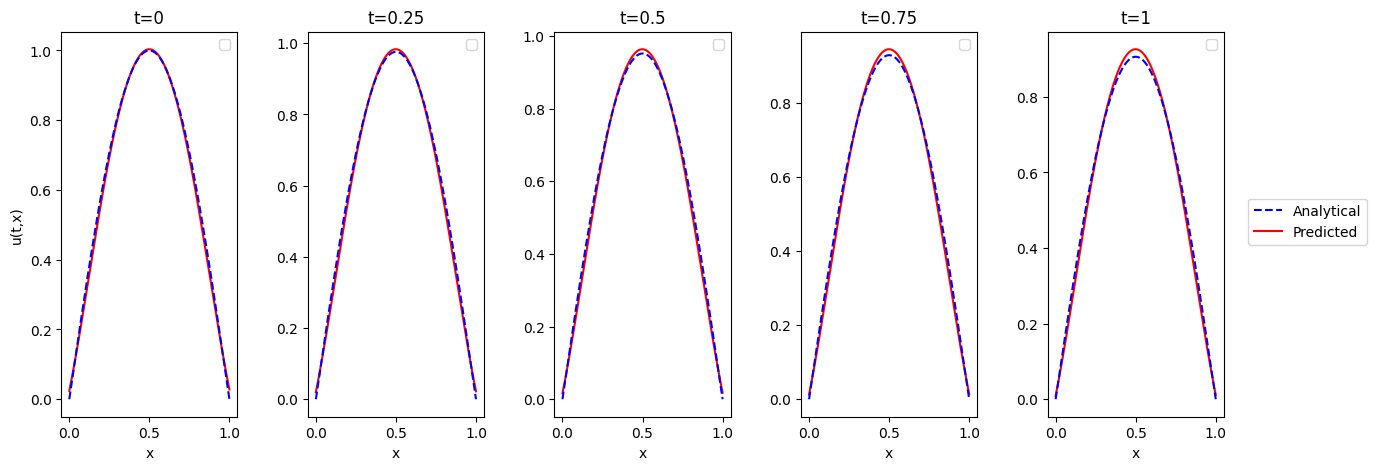

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches



# Define the analytical solution function
def analytical_solution(t, x):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

# Your provided data and setup
t_cross_sections = [0, 0.25, 0.5, 0.75, 1]
x_span = np.linspace(0, 1, N)  # Adjust as needed
#alpha = 1  # Specify the correct alpha for your problem

fig, axs = plt.subplots(1, len(t_cross_sections), figsize=(15, 5))  # Adjust figsize as needed

# Assuming 'model' and 'device' are defined
# Ensure your model is in evaluation mode
model.eval()

for i, t_cs in enumerate(t_cross_sections):
    axs[i].set_title(f't={t_cs}')
    axs[i].set_xlabel('x')
    if i == 0:
        axs[i].set_ylabel('u(t,x)')

    # Calculate the analytical solution for this time cross-section
    u_analytical = analytical_solution(t_cs, x_span)

    # Prepare the input for the model
    t_x = np.stack([np.full(x_span.shape, t_cs), x_span], axis=-1)
    t_x_tensor = torch.tensor(t_x, dtype=torch.float32).to(device)

    # Get the model's prediction
    with torch.no_grad():  # No need to track gradients here
        u_pred = model(t_x_tensor.double().to(device)).cpu().numpy()

    # Plotting the predictions and analytical solutions
    axs[i].plot(x_span, u_pred.flatten(), color='r')  # Adjust color as needed
    axs[i].plot(x_span, u_analytical, linestyle='dashed', color='b')  # Adjust color as needed

    # Add legend to each subplot
    axs[i].legend()

# Adjust the layout
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

analytical_handle = mlines.Line2D([], [], color='blue', linestyle='dashed', label='Analytical solution')
predicted_handle = mlines.Line2D([], [], color='red', label='Predicted')

# Create a single legend
fig.legend(handles=[analytical_handle, predicted_handle],
           labels=['Analytical', 'Predicted'],
           loc='center right', bbox_to_anchor=(1, 0.5))






plt.show()


# Code for the pytorch functions vpj and jvp.

In [ ]:
def f(x):
  return torch.sin(x) * x ** 2

In [ ]:
x = torch.tensor(2.)
y = f(x)
print(y)

tensor(3.6372)


In [ ]:
delta_x = torch.tensor(1.)
y, delta_y = torch.autograd.functional.jvp(f, (x,), (delta_x,))
print(y)
print(delta_y)

tensor(3.6372)
tensor(1.9726)


In [ ]:
eps = 1e-4
v=delta_x
delta_y_approx = (f(x + eps * v) - f(x)) / eps
print(delta_y_approx)

tensor(1.9717)


In [ ]:
def g(x):
  return 2*x**2+3*x-2

In [ ]:
x=torch.tensor(2.0)
delta_x = torch.tensor(.1)
y, delta_y = torch.autograd.functional.jvp(g, (x,), (delta_x,))
print(y)
print(delta_y)

tensor(12.)
tensor(1.1000)


In [ ]:
eps = 1e-5
v=delta_x
delta_y_approx = (g(x + eps * v) - g(x)) / eps
print(delta_y_approx)

tensor(1.0490)


In [ ]:
f_prime=(g(x+eps*v)-g(x))/(eps)
f_prime

tensor(1.0490)

In [ ]:
w=torch.tensor(.5)
y, lmbda =torch.autograd.functional.vjp(g,(w,),(delta_y,))

print(y)
print(lmbda)



tensor(0.)
(tensor(5.5000),)


In [ ]:
delta_y

tensor(1.1000)

# Application of jvp.

In [ ]:
def heat(t,x):
  if not isinstance(t, torch.Tensor):
        t = torch.tensor(t, dtype=torch.float64, requires_grad=True)
  if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float64, requires_grad=True)
  x = x.double().view(-1, 1).requires_grad_(True)
  t = t.double().view(-1, 1).requires_grad_(True)

  xt=torch.cat((t,x), dim=1)
  #print(xt)
  return model(xt.double().to(device))


In [ ]:
heat(0.0,0.4)

tensor([[0.9506]], device='cuda:0', dtype=torch.float64,
       grad_fn=<GeluBackward0>)

In [ ]:
h=partial(heat,0.0)

In [ ]:
h(0.4)

tensor([[0.9506]], device='cuda:0', dtype=torch.float64,
       grad_fn=<GeluBackward0>)

In [ ]:
x_test = torch.tensor(0.4, requires_grad=True, dtype=torch.float64)
y_test = h(x_test)
print(y_test)


tensor([[0.9506]], device='cuda:0', dtype=torch.float64,
       grad_fn=<GeluBackward0>)


In [ ]:
y_test.backward()

# Check the gradient
print(x_test.grad)  # Should be non-zero for a correct implementation


tensor(0.7409, dtype=torch.float64)


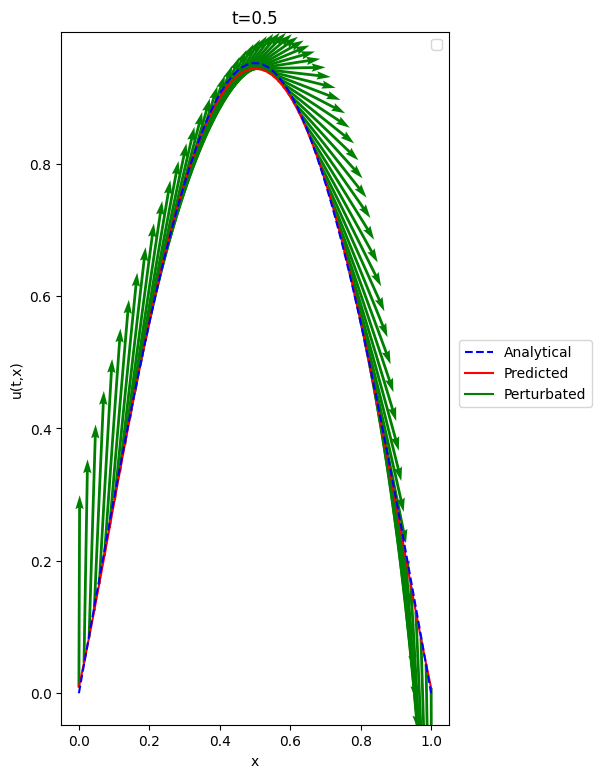

In [ ]:


import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Define the analytical solution function
def analytical_solution(t, x):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

# Your provided data and setup
t_cross_sections = [ 0.5]

x_span = np.linspace(0, 1, 70)  # Adjust as needed

fig, axs = plt.subplots(1, len(t_cross_sections), figsize=(5, 9))  # Adjust figsize as needed

# Assuming 'model' and 'device' are defined
# Ensure your model is in evaluation mode
model.eval()
axs.set_title(f't={t_cs}')
axs.set_xlabel('x')
axs.set_ylabel('u(t,x)')

# Calculate the analytical solution for this time cross-section
u_analytical = analytical_solution(t_cs, x_span)

# Prepare the input for the model
t_x = np.stack([np.full(x_span.shape, t_cs), x_span], axis=-1)
t_x_tensor = torch.tensor(t_x, dtype=torch.float32).requires_grad_(True)


model.eval()  # Ensure your model is in evaluation mode
# Define a differentiable function that returns model output
def model_output(tx):
  return model(tx.double().to(device))

u_pred = model_output(t_x_tensor)
# We nudge x by delta_x and this gives delta_y change
x=torch.tensor(x_span).view(-1,1)

nudge=np.ones(x_span.shape[0])*1.01
delta_x = np.stack([np.full(x_span.shape, t_cs), nudge], axis=-1)
delta_x_tensor = torch.tensor(delta_x, dtype=torch.float32).requires_grad_(True)

y, delta_y = torch.autograd.functional.jvp(model_output, (t_x_tensor,), (delta_x_tensor,))
axs.quiver(x_span,u_pred.detach().cpu(), y.detach().cpu(),delta_y.detach().cpu(),scale=5,color='green')


# Plotting the predictions and analytical solutions
axs.plot(x_span, u_pred.detach().cpu().flatten(), color='r')  # Adjust color as needed
axs.plot(x_span, u_analytical,  linestyle='dashed', color='b')  # Adjust color as needed

# Add legend to each subplot
axs.legend()

# Adjust the layout
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

analytical_handle = mlines.Line2D([], [], color='blue', linestyle='dashed', label='Analytical solution')
predicted_handle = mlines.Line2D([], [], color='red', label='Predicted')
perturbated_handle = mlines.Line2D([],[], color='green', label='Perturbated')

# Create a single legend
fig.legend(handles=[analytical_handle, predicted_handle, perturbated_handle],
           labels=['Analytical', 'Predicted', 'Perturbated'],
           loc='right', bbox_to_anchor=(1.2, 0.5))

plt.show()


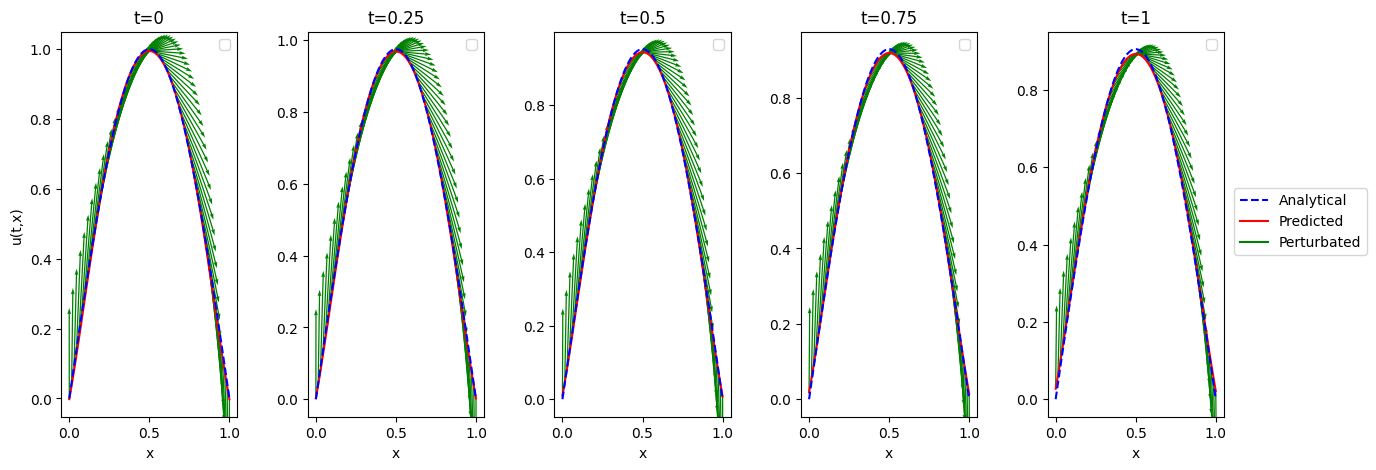

In [ ]:

# The original

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Define the analytical solution function
def analytical_solution(t, x):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

# Your provided data and setup
t_cross_sections = [0, 0.25, 0.5, 0.75, 1]

x_span = np.linspace(0, 1, 70)  # Adjust as needed
#alpha = 1  # Specify the correct alpha for your problem

fig, axs = plt.subplots(1, len(t_cross_sections), figsize=(15, 5))  # Adjust figsize as needed

# Assuming 'model' and 'device' are defined
# Ensure your model is in evaluation mode
model.eval()

for i, t_cs in enumerate(t_cross_sections):
    axs[i].set_title(f't={t_cs}')
    axs[i].set_xlabel('x')
    if i == 0:
        axs[i].set_ylabel('u(t,x)')

    # Calculate the analytical solution for this time cross-section
    u_analytical = analytical_solution(t_cs, x_span)

    # Prepare the input for the model
    t_x = np.stack([np.full(x_span.shape, t_cs), x_span], axis=-1)
    t_x_tensor = torch.tensor(t_x, dtype=torch.float32).requires_grad_(True)

    # Get the model's prediction
    #with torch.no_grad():  # No need to track gradients here

    model.eval()  # Ensure your model is in evaluation mode

    # Define a differentiable function that returns model output
    def model_output(tx):
      return model(tx.double().to(device))

    u_pred = model_output(t_x_tensor)
    #h=partial(heat,t_cs)
    # We nudge x by delta_x and this gives delta_y change
    x=torch.tensor(x_span).view(-1,1)
    #print(h(x).shape)

    nudge=np.ones(x_span.shape[0])*1.01
    delta_x = np.stack([np.full(x_span.shape, t_cs), nudge], axis=-1)
    delta_x_tensor = torch.tensor(delta_x, dtype=torch.float32).requires_grad_(True)
    #delta_x = torch.tensor(0.01, requires_grad=True).view(-1,1)

    #print(delta_x.shape)
    y, delta_y = torch.autograd.functional.jvp(model_output, (t_x_tensor,), (delta_x_tensor,))
    #print(delta_y)
    axs[i].quiver(x_span,u_pred.detach().cpu(), y.detach().cpu(),delta_y.detach().cpu(),scale=5,color='green')


    # Plotting the predictions and analytical solutions
    axs[i].plot(x_span, u_pred.detach().cpu().flatten(), color='r')  # Adjust color as needed
    axs[i].plot(x_span, u_analytical,  linestyle='dashed', color='b')  # Adjust color as needed

    # Add legend to each subplot
    axs[i].legend()

# Adjust the layout
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

analytical_handle = mlines.Line2D([], [], color='blue', linestyle='dashed', label='Analytical solution')
predicted_handle = mlines.Line2D([], [], color='red', label='Predicted')
perturbated_handle = mlines.Line2D([],[], color='green', label='Perturbated')

# Create a single legend
fig.legend(handles=[analytical_handle, predicted_handle, perturbated_handle],
           labels=['Analytical', 'Predicted', 'Perturbated'],
           loc='center right', bbox_to_anchor=(1, 0.5))



plt.show()


In [ ]:
# We nudge x by delta_x and this gives delta_y change
x=torch.tensor(0.4).view(-1,1)
delta_x = torch.tensor(0.01, requires_grad=True).view(-1,1)
y, delta_y = torch.autograd.functional.jvp(h, (x,), (delta_x,))
print(y) # du kan skrive .item() så kommer de ud i numpy
print(delta_y)

tensor([[0.9510]], device='cuda:0', dtype=torch.float64)
tensor([[0.0094]], device='cuda:0', dtype=torch.float64)


# Application of vjp.

In [ ]:
w=torch.tensor(.4)
#delta_y=torch.tensor(1.0)

y, g_vjp =torch.autograd.functional.vjp(h,w,delta_y)
lmbda = g_vjp
print(y)
print(lmbda)

tensor([[0.9390]], device='cuda:0', dtype=torch.float64)
tensor(0.0055)


In [ ]:
delta_y

tensor(11.)

In [ ]:
g(delta_y)

tensor(3.)

#Computation Graph

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=d3a72f9e5b6139b40b98242537092a71eae49013e0c8878e5f41a72fce48c911
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
#import torch

# Enable gradient tracking
x = torch.tensor([1.0], requires_grad=True)

# Perform operations
u1 = x**3
f = torch.sin(u1)

# Print the operations
print("Forward graph:")
print("u1:", u1)
print("u1.grad_fn:", u1.grad_fn)
print("f:", f)
print("f.grad_fn:", f.grad_fn)

# Perform backpropagation
f.backward( retain_graph=True)

# Print gradient with respect to x
print("Gradient of f with respect to x:", x.grad)


Forward graph:
u1: tensor([1.], grad_fn=<PowBackward0>)
u1.grad_fn: <PowBackward0 object at 0x7c84a40d3250>
f: tensor([0.8415], grad_fn=<SinBackward0>)
f.grad_fn: <SinBackward0 object at 0x7c84a40d3250>
Gradient of f with respect to x: tensor([1.6209])


In [ ]:
import torch
# Create tensors for x1 and x2 and enable gradient tracking
x1 = torch.tensor([2.0], requires_grad=True)
x2 = torch.tensor([5.0], requires_grad=True)
# Forward Mode:
# Defining the function: f(x1, x2) = exp(x1) + x1 * x2 - cos(x2)
# This is the forward pass, where we compute the output of the function
# as well as set up the computational graph for backpropagation.
u1=torch.exp(x1)
u2=x1*x2
u3=torch.cos(x2)
f = u1 + u2 -u3
# Print the operations
print("Forward graph:")
du1_dx1=grad(u1,x1,retain_graph=True)[0]
print("u1.grad:", du1_dx)
du2_dx1=grad(u2,x1,retain_graph=True)[0]
print("u2.grad:",du2_dx )
du3_dx1=grad(u3,x1,allow_unused=True,retain_graph=True)[0]
du3_dx1 = du3_dx1 if du3_dx1 is not None else torch.tensor([0.0])
print("u3.grad:",du3_dx1 )
print('df_dx1',du1_dx1.item()+du2_dx1.item()+du3_dx1.item())

print('')
print('Reverse mode')
# Reverse Mode (Automatic Differentiation/Backpropagation):
# When we call backward(), PyTorch traverses the computational graph
# in reverse, computing gradients of f with respect to x1 and x2.
f.backward(retain_graph=True)
# The gradients are computed and stored in x1.grad and x2.grad.
# These gradients represent df/dx1 and df/dx2.
grad_x1 = x1.grad
grad_x2 = x2.grad
print("Reverse mode - Gradient with respect to x1:", grad_x1.item())
print("Reverse mode - Gradient with respect to x2:", grad_x2.item())


Forward graph:
u1.grad: (tensor([7.3891]),)
u2.grad: (tensor([5.]),)
u3.grad: tensor([0.])
df_dx1 12.389056205749512

Reverse mode
Reverse mode - Gradient with respect to x1: 12.389056205749512
Reverse mode - Gradient with respect to x2: 1.0410757064819336


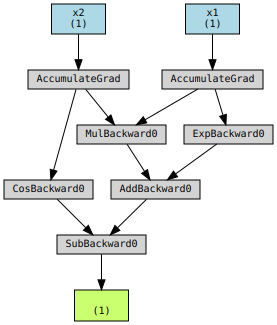

In [ ]:

from torchviz import make_dot

#make_dot(f, params={'x1': x1}, show_attrs=True)
make_dot(f, params={'x1': x1,'x2':x2})


In [ ]:
x1=2
x2=5

In [ ]:
v0=x2
vsub1=x1

In [ ]:
vbar5=1

vbar4=vbar5*1
vbar3=vbar5*-1
vbar1=vbar4*1
vbar2=vbar4*1
vbar0=vbar3*(-np.sin(v0))
vbarsub1=vbar2*v0
vbar0=vbar0+vbar2*vsub1
vbarsub1=vbarsub1+np.exp(vsub1)

In [ ]:
vbar0

1.0410757253368614

In [ ]:
vbarsub1

12.38905609893065